Load HyperParameters

In [1]:
from neat_src import loadHyp, updateHyp
from domain import load_task
from domain.config import games
from domain.task_gym import GymTask

game = games["slimevolley"]
task = GymTask(game)

hyp_default = 'p/default_sneat.json'
hyp_adjust = "p/volley.json"
fileName = "volley"

hyp = loadHyp(pFileName=hyp_default, load_task=load_task)
updateHyp(hyp,load_task,hyp_adjust)

hyp["cap_layer"] = 3
# neat = Neat(hyp)

	*** Running with hyperparameters:  p/volley.json 	***


#### Convert Policy model to Ind in Neat 

In [2]:
import json
import numpy as np
import gym, os
import slimevolleygym
import slimevolleygym.mlp as mlp
from slimevolleygym.mlp import games as games
from slimevolleygym.mlp import Model
from slimevolleygym import multiagent_rollout as rollout

game = games['slimevolleylite']



# of Connections in ANN:  51


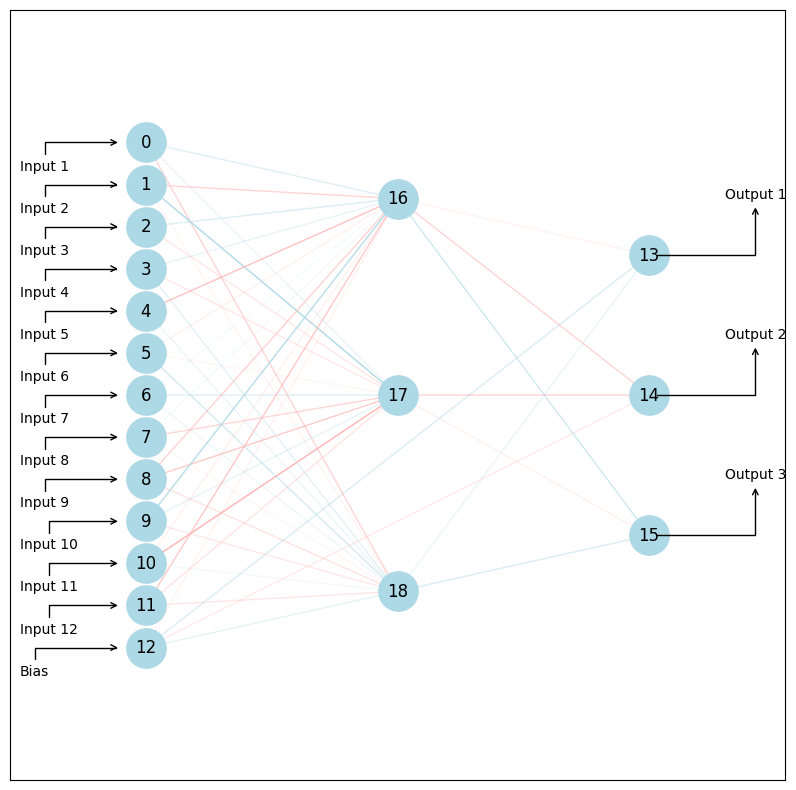

In [3]:
# Slime Environment Specific model -> Ind convertion function 
from neat_src import Ind, initIndiv
from vis.viewInd import viewInd 

temp_shapes = [(12, 3), (3, 3)] # debug getlayer functional variable 

indiv = Ind.from_shapes(temp_shapes)
indiv.express()

# visualize individual network 
fig, ax = viewInd(indiv, "slimevolley") # this is in-correct, edge is not correctly assigned ...

In [4]:
# Indiv --> Policy Model 
game = games['slimevolleylite']
load_policy = Model.from_indiv(indiv, game)

In [9]:
load_policy.predict(np.ones(12))

array([ 0.525,  0.636, -0.342])

In [11]:
l = len(load_policy.shapes)
l-1

2

In [8]:
# indiv.to_params()
indiv.express()
indiv.max_layer

2

In [20]:
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import io

# Convert matplotlib figure to PIL Image
def fig2img(fig):
    # Save figure to a temporary buffer.
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    return Image.open(buf)


# def animate_mutations(shapes, hyp, generations: int = 200, save_name: str = "network_evolution.gif"):
    
frames = []  # Store frames

prev_indiv = Ind.from_shapes([(12, 3)])
prev_indiv.express()

hyp['prob_addNode'] = 0.5
hyp['prob_addConn'] = 0.3
hyp['cap_layer'] = 4
hyp['stop_topology_mutate_generations'] = 200


matplotlib.use('Agg')  # Use Agg backend for better memory management
gen = 1
# Generate and store frames
for i in range(250):
    
    child, innov = prev_indiv.mutate(hyp, gen=gen)    
    if child is False: 
        print("Failed to express :: Bad mutation")
        # break 
    else:
        fig, ax = viewInd(child, "slimevolley")
        prev_indiv = child 
        gen += 1 
        img = fig2img(fig)
        frames.append(img)
        plt.close(fig)

    
# Save frames as GIF directly using PIL
frames[0].save(
    'network_evolution_mix.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration for each frame in milliseconds
    loop=0        # 0 means loop forever
)

# of Connections in ANN:  41
# of Connections in ANN:  43
# of Connections in ANN:  43
# of Connections in ANN:  45
# of Connections in ANN:  46
# of Connections in ANN:  48
# of Connections in ANN:  50
# of Connections in ANN:  53
# of Connections in ANN:  55
# of Connections in ANN:  58
# of Connections in ANN:  58
# of Connections in ANN:  60
# of Connections in ANN:  60
# of Connections in ANN:  61
# of Connections in ANN:  62
# of Connections in ANN:  65
# of Connections in ANN:  65
# of Connections in ANN:  67
# of Connections in ANN:  67
# of Connections in ANN:  68
# of Connections in ANN:  69
# of Connections in ANN:  71
# of Connections in ANN:  72
# of Connections in ANN:  74
# of Connections in ANN:  75
# of Connections in ANN:  75
# of Connections in ANN:  78
# of Connections in ANN:  80
Failed to express :: Bad mutation
# of Connections in ANN:  80
# of Connections in ANN:  81
# of Connections in ANN:  83
# of Connections in ANN:  84
# of Connections in ANN:  84
# of Conn

KeyboardInterrupt: 

In [29]:
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import io

# Convert matplotlib figure to PIL Image
def fig2img(fig):
    # Save figure to a temporary buffer.
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    return Image.open(buf)


# def animate_mutations(shapes, hyp, generations: int = 200, save_name: str = "network_evolution.gif"):
    
frames = []  # Store frames

prev_indiv = Ind.from_shapes([(12, 3)])
prev_indiv.express()

hyp['prob_addNode'] = 0.5
hyp['prob_addConn'] = 0.3
hyp['cap_layer'] = 4
hyp['stop_topology_mutate_generations'] = 200


matplotlib.use('Agg')  # Use Agg backend for better memory management
gen = 1
# Generate and store frames
for i in range(250):
    
    child, innov = prev_indiv.mutate(hyp, gen=gen)    
    if child is False: 
        print("Failed to express :: Bad mutation")
        # break 
    else:
        fig, ax = viewInd(child, "slimevolley")
        prev_indiv = child 
        gen += 1 
        img = fig2img(fig)
        frames.append(img)
        plt.close(fig)
        
        # ToBeDone :: Make the Model conversion works ....        
        print("Initializing VolleyBall Agent MLP ...")
        policy_model = Model.from_indiv(child, game)
        try:
            policy_model.predict(np.ones(12))
        except Exception as e:
            print("Failed to propagate through the network ...")
            print(f"Error: {e}")
        

    
# Save frames as GIF directly using PIL
frames[0].save(
    'network_evolution_mix.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration for each frame in milliseconds
    loop=0        # 0 means loop forever
)

# of Connections in ANN:  42
# of Connections in ANN:  45
# of Connections in ANN:  46
# of Connections in ANN:  46
# of Connections in ANN:  46
# of Connections in ANN:  47
# of Connections in ANN:  47
# of Connections in ANN:  50
# of Connections in ANN:  50
# of Connections in ANN:  53
# of Connections in ANN:  54
# of Connections in ANN:  57
# of Connections in ANN:  59
# of Connections in ANN:  61
# of Connections in ANN:  61


KeyboardInterrupt: 

In [26]:
# ok, so crossover also works .... | but I'd like to stick to the basic idea (replacing mutation gadgets in the tournament based GA environment)

hyp['prob_addNode'] = 0.5
hyp['prob_addConn'] = 0.3
hyp['cap_layer'] = 4
hyp['stop_topology_mutate_generations'] = 200
hyp['prob_mutConn'] = 1.0 
hyp['ann_mutSigma'] = 0.1 



In [28]:
indiv

In [12]:
# Test on Simple Neat Training Script here: 

In [26]:
import os
import numpy as np
import gym
from slimevolleygym.mlp import games as games
from slimevolleygym.mlp import Model
from slimevolleygym import multiagent_rollout as rollout
from neat_src import loadHyp, updateHyp, Ind
from domain import load_task


# Settings
random_seed = 612
population_size = 128
total_tournaments = 5000
save_freq = 1000

# Environment

# Hyperparameters
hyp_default = 'p/default_sneat.json'
hyp_adjust = "p/volley.json"

hyp = loadHyp(pFileName=hyp_default, load_task=load_task)
updateHyp(hyp,load_task,hyp_adjust)

# Log results
logdir = "../runs/sneat_sp"
if not os.path.exists(logdir):
  os.makedirs(logdir)

def mutate(ind, p): 
    child, _ = ind.mutate(p=p)
    if child is None: 
        child, _ = ind.mutate(p=p, mute_top_change=True)
    if child: 
        return child 
    else:
        print("Failed Mutation --- with muted topology change ??")
        return ind


game = games['slimevolleylite']
population = [Ind.from_shapes([(game.input_size, 3), (3, game.output_size)]) for _ in range(population_size)]
winning_streak = [0] * population_size # store the number of wins for this agent (including mutated ones)

# create the gym environment, and seed it
env = gym.make("SlimeVolley-v0")
env.seed(random_seed)
np.random.seed(random_seed)

	*** Running with hyperparameters:  p/volley.json 	***


In [27]:

history = []
for tournament in range(1, total_tournaments+1):
  
  # Random Pick Two Agents from Population
  left_idx, right_idx = np.random.choice(population_size, 2, replace=False)
  
  policy_right = Model.from_indiv(population[right_idx], game)
  policy_left = Model.from_indiv(population[left_idx], game)

  # Match between two agents
  score, length = rollout(env, policy_right, policy_left)
  
  history.append(length)
  
  # if score is positive, it means policy_right won.
  if score == 0: # if the game is tied, add noise to the left agent
    population[left_idx] = mutate(population[left_idx], p=hyp)
  elif score > 0:
    population[left_idx] = mutate(population[right_idx], p=hyp)
    winning_streak[left_idx] = winning_streak[right_idx]
    winning_streak[right_idx] += 1
  else:
    population[right_idx] = mutate(population[left_idx], p=hyp)
    winning_streak[right_idx] = winning_streak[left_idx]
    winning_streak[left_idx] += 1

Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??
Failed Mutation --- with muted topology change ??


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 12)

In [ ]:
# loop through mutation and check for can-not-compile cases ... 



In [25]:
# w_ind.save("w_ind.json")
w_ind =Ind.load("w_ind.json")
w_ind.express()

from vis.viewInd import viewInd, getLayer

layer = getLayer(w_ind.wMat)

fig, ax = viewInd(w_ind, "slimevolley")
fig

# of Connections in ANN:  8


ValueError: operands could not be broadcast together with shapes (1,9) (21,) 

In [24]:
sum(w_ind.conn[3] == 0)


0

In [14]:
ind = w_ind
from vis.viewInd import ind2graph

wMat = ind.wMat
aVec = np.zeros((np.shape(wMat)[0]))  
print('# of Connections in ANN: ', np.sum(wMat!=0))

# Create Graph
nIn = ind.nInput + ind.nBias # fixed 
nOut= ind.nOutput
G, layer= ind2graph(wMat, nIn, nOut) # pass | G is off by one node (likely hidden node is missing?)

# of Connections in ANN:  8


In [19]:
G

In [16]:
w_conn = w_ind.conn 
w_conn[1:3, w_conn[2, :] == 16]


from neat_src.ann import getNodeMap 
g = getNodeMap(w_ind.node, w_ind.conn)
g

{0: [0, 0],
 1: [0, 1],
 2: [0, 2],
 3: [0, 3],
 4: [0, 4],
 5: [0, 5],
 6: [0, 6],
 7: [0, 7],
 8: [0, 8],
 9: [0, 9],
 10: [0, 10],
 11: [0, 11],
 12: [0, 12],
 16: [1, 13],
 17: [1, 14],
 18: [1, 15],
 19: [1, 16],
 20: [1, 17],
 13: [2, 18],
 14: [2, 19],
 15: [2, 20]}

In [ ]:
# Issue: Mismatch weight shape --- we could add node at zero layer ??? 

In [19]:
indiv = population[left_idx]
child, _ = indiv.mutate(hyp, gen=1, mute_top_change=True)
child